In [19]:
import numpy as np
import optuna
import sys
import joblib
import pandas as pd
import json
import matplotlib.pyplot as plt
import matplotlib
import lightgbm as lgb
import xgboost as xgb 
from sklearn.ensemble import RandomForestRegressor
import pickle

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [2]:
output_dir = '../../split_year_models'

### Loading Data

In [106]:
filepath = '../../split_year_data'

In [107]:
train = {}
for fold in range(0, 5):
    tdata_x85 = pd.read_csv(filepath + '/train/X_train_' + str(fold) + '_85.csv')
    tdata_x85 = tdata_x85.drop(columns=['Unnamed: 0'], axis=1)
    tdata_y85 = pd.read_csv(filepath + '/train/y_train_' + str(fold) + '_85.csv')
    tdata_y85 = tdata_y85.drop(columns=['Unnamed: 0'], axis=1)

    tdata_x95 = pd.read_csv(filepath + '/train/X_train_' + str(fold) + '_95.csv')
    tdata_x95 = tdata_x95.drop(columns=['Unnamed: 0'], axis=1)
    tdata_y95 = pd.read_csv(filepath + '/train/y_train_' + str(fold) + '_95.csv')
    tdata_y95 = tdata_y95.drop(columns=['Unnamed: 0'], axis=1)

    tdata_x1 = pd.read_csv(filepath + '/train/X_train_' + str(fold) + '_1.csv')
    tdata_x1 = tdata_x1.drop(columns=['Unnamed: 0'], axis=1)
    tdata_y1 = pd.read_csv(filepath + '/train/y_train_' + str(fold) + '_1.csv')
    tdata_y1 = tdata_y1.drop(columns=['Unnamed: 0'], axis=1)

    train[fold] = [tdata_x85, tdata_y85, tdata_x95, tdata_y95, tdata_x1, tdata_y1]

In [108]:
test_data_x = pd.read_csv(filepath + '/test/X_test.csv')
test_data_x = test_data_x.drop(columns=['Unnamed: 0'], axis=1)
test_data_y = pd.read_csv(filepath + '/test/y_test.csv')
test_data_y = test_data_y.drop(columns=['Unnamed: 0'], axis=1)

In [109]:
with open('../../split_year_data/countries_dict.pkl', 'rb') as f:
    countries_dict = pickle.load(f)

### Setting up Tables

In [143]:
# setting up the dataframe to hold test results
index_rows = pd.MultiIndex.from_tuples(
    [('Threshold 85%', '1'), ('Threshold 85%', '2'), ('Threshold 85%', '3'), ('Threshold 85%', '4'), ('Threshold 85%', '5'),
     ('Threshold 95%', '1'), ('Threshold 95%', '2'), ('Threshold 95%', '3'), ('Threshold 95%', '4'), ('Threshold 95%', '5'),
     ('None', '1'), ('None', '2'), ('None', '3'), ('None', '4'), ('None', '5')],
    names=['Missing Data Threshold', 'Fold']
)

index_cols = pd.MultiIndex.from_tuples(
    [('LightGBM', 'MAPE'), ('LightGBM', 'MAE'), ('LightGBM', 'MSE'), ('LightGBM', 'RMSE'), ('LightGBM', 'R2'), 
     ('XGBoost', 'MAPE'), ('XGBoost', 'MAE'), ('XGBoost', 'MSE'), ('XGBoost', 'RMSE'), ('XGBoost', 'R2'),
     ('Random Forest', 'MAPE'), ('Random Forest', 'MAE'), ('Random Forest', 'MSE'), ('Random Forest', 'RMSE'), ('Random Forest', 'R2')],
    names=['Model', 'Evaluation Metric']
)

test_stats = pd.DataFrame(index=index_rows, columns=index_cols)

test_stats

Model                       LightGBM                     XGBoost            \
Evaluation Metric               MAPE  MAE  MSE RMSE   R2    MAPE  MAE  MSE   
Missing Data Threshold Fold                                                  
Threshold 85%          1         NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN   
                       2         NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN   
                       3         NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN   
                       4         NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN   
                       5         NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN   
Threshold 95%          1         NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN   
                       2         NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN   
                       3         NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN   
                       4         NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN   
                       5         NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN   
None                   1         NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN   
                       2         NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN   
                       3         NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN   
                       4         NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN   
                       5         NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN   

Model                                 Random Forest                      
Evaluation Metric           RMSE   R2          MAPE  MAE  MSE RMSE   R2  
Missing Data Threshold Fold                                              
Threshold 85%          1     NaN  NaN           NaN  NaN  NaN  NaN  NaN  
                       2     NaN  NaN           NaN  NaN  NaN  NaN  NaN  
                       3     NaN  NaN           NaN  NaN  NaN  NaN  NaN  
                       4     NaN  NaN           NaN  NaN  NaN  NaN  NaN  
                       5     NaN  NaN           NaN  NaN  NaN  NaN  NaN  
Threshold 95%          1     NaN  NaN           NaN  NaN  NaN  NaN  NaN  
                       2     NaN  NaN           NaN  NaN  NaN  NaN  NaN  
                       3     NaN  NaN           NaN  NaN  NaN  NaN  NaN  
                       4     NaN  NaN           NaN  NaN  NaN  NaN  NaN  
                       5     NaN  NaN           NaN  NaN  NaN  NaN  NaN  
None                   1     NaN  NaN           NaN  NaN  NaN  NaN  NaN  
                       2     NaN  NaN           NaN  NaN  NaN  NaN  NaN  
                       3     NaN  NaN           NaN  NaN  NaN  NaN  NaN  
                       4     NaN  NaN           NaN  NaN  NaN  NaN  NaN  
                       5     NaN  NaN           NaN  NaN  NaN  NaN  NaN

### LightGBM

#### Data Collection

In [144]:
# setting up the dataframe to hold test results
rows_params = pd.MultiIndex.from_tuples(
    [('Threshold 85%', '1'), ('Threshold 85%', '2'), ('Threshold 85%', '3'), ('Threshold 85%', '4'), ('Threshold 85%', '5'),
     ('Threshold 95%', '1'), ('Threshold 95%', '2'), ('Threshold 95%', '3'), ('Threshold 95%', '4'), ('Threshold 95%', '5'),
     ('None', '1'), ('None', '2'), ('None', '3'), ('None', '4'), ('None', '5')],
    names=['Missing Data Threshold', 'Fold']
)

lgbm_params = pd.DataFrame(index=index_rows, columns=['number_trees', 'max_tree_depth', 'boosting_type', 
                                                     'bagging_fraction', 'bagging_freq', 'learning_rate',
                                                     'l1_norm', 'l2_norm'])

In [145]:
test_data_x['setting'] = test_data_x['setting'].astype("category")
testing_x = test_data_x.copy()
testing_x.columns = testing_x.columns.str.replace(r'[\"\[\]\{\}\\:,]', '', regex=True)

for fold, fold_num in enumerate(['1', '2', '3', '4', '5']):
    for thresh, thresh_name in enumerate(['Threshold 85%', 'Threshold 95%', 'None']):
        
        if thresh == 0:
            name = '85'
        elif thresh == 1:
            name = '95'
        else: name = '1'

        best_params = joblib.load(f"{output_dir}/lightgbm/best_params_{fold}_{name}.pkl")
        param_list = list(best_params.values())
        lgbm_params.loc[(thresh_name, fold_num)] = param_list
        best_model = joblib.load(f"{output_dir}/lightgbm/best_params_{fold}_{name}.pkl")

        train_input_data = train[fold][thresh * 2].copy()
        train_input_data['setting'] = train_input_data['setting'].astype("category")
        train_input_data.columns = train_input_data.columns.str.replace(r'[\"\[\]\{\}\\:,]', '', regex=True)

        train_label = train[fold][thresh * 2 + 1].copy()
        train_label.column = 'Maternal mortality ratio (national estimate per 100000 live births)'

        columns_needed = testing_x.columns.intersection(train_input_data.columns)
        to_test = testing_x[columns_needed].copy()

        loaded_model = lgb.LGBMRegressor(**best_params, verbosity = -1)
        train_load = loaded_model.fit(train_input_data, train_label)
        prediction = train_load.predict(to_test)
        mse = mean_squared_error(test_data_y, prediction)
        mae = mean_absolute_error(test_data_y, prediction)
        rmse = np.sqrt(mse)
        r2 = r2_score(test_data_y, prediction)

        #to calculate mape
        num_predictions = len(prediction)
        mape = 0
        for p in range(0, num_predictions):
            mape += np.abs(prediction[p] - test_data_y.iloc[p]) / np.maximum(np.abs(prediction[p]), np.abs(test_data_y.iloc[p]))
        mape = mape/num_predictions
        #mape = (1/num_predictions) * np.sum(np.abs(prediction - test_data_y) / np.max(np.abs(prediction), np.abs(test_data_y)))

        test_stats.loc[(thresh_name, fold_num), ('LightGBM', 'MSE')] = mse
        test_stats.loc[(thresh_name, fold_num), ('LightGBM', 'MAE')] = mae
        test_stats.loc[(thresh_name, fold_num), ('LightGBM', 'RMSE')] = rmse
        test_stats.loc[(thresh_name, fold_num), ('LightGBM', 'R2')] = r2
        test_stats.loc[(thresh_name, fold_num), ('LightGBM', 'MAPE')] = mape[0]
        

/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_28867/2913240475.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_stats.loc[(thresh_name, fold_num), ('LightGBM', 'MAPE')] = mape[0]
/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_28867/2913240475.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_stats.loc[(thresh_name, fold_num), ('LightGBM', 'MAPE')] = mape[0]
/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_28867/2913240475.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as lab

#### Visualisations

In [146]:
lgbm_params

number_trees max_tree_depth boosting_type  \
Missing Data Threshold Fold                                             
Threshold 85%          1             252             21          dart   
                       2              39             22          dart   
                       3             216             15          dart   
                       4             260              7          dart   
                       5             255             13          dart   
Threshold 95%          1             213              8          dart   
                       2             143              7          dart   
                       3             264             18          gbdt   
                       4              20             25          gbdt   
                       5             159             23          gbdt   
None                   1             282             24          dart   
                       2              90              7          dart   
                       3             286              7          dart   
                       4             132             17          dart   
                       5             121             17          gbdt   

                            bagging_fraction bagging_freq learning_rate  \
Missing Data Threshold Fold                                               
Threshold 85%          1            0.464229            2       0.08414   
                       2            0.614898            3      0.167899   
                       3            0.966297            0      0.630838   
                       4            0.454591           10      0.106648   
                       5            0.831813            9      0.921948   
Threshold 95%          1            0.534532            7      0.111564   
                       2            0.504432            0      0.094069   
                       3            0.826114            5      0.123807   
                       4            0.617536            0      0.125973   
                       5            0.673521           10      0.058796   
None                   1            0.531009            6      0.110417   
                       2            0.257989            1      0.299737   
                       3            0.660253            1      0.389922   
                       4            0.863737            1      0.308982   
                       5            0.483387            2      0.198818   

                              l1_norm   l2_norm  
Missing Data Threshold Fold                      
Threshold 85%          1     0.000045  0.000197  
                       2     0.000571  0.000459  
                       3     0.000912  0.000817  
                       4     0.000453  0.000915  
                       5     0.000317  0.000932  
Threshold 95%          1     0.000805  0.000762  
                       2     0.000081  0.000617  
                       3     0.000968   0.00094  
                       4     0.000706  0.000292  
                       5      0.00006  0.000905  
None                   1     0.000707   0.00005  
                       2     0.000052  0.000604  
                       3     0.000555  0.000107  
                       4      0.00001  0.000431  
                       5     0.000726   0.00074

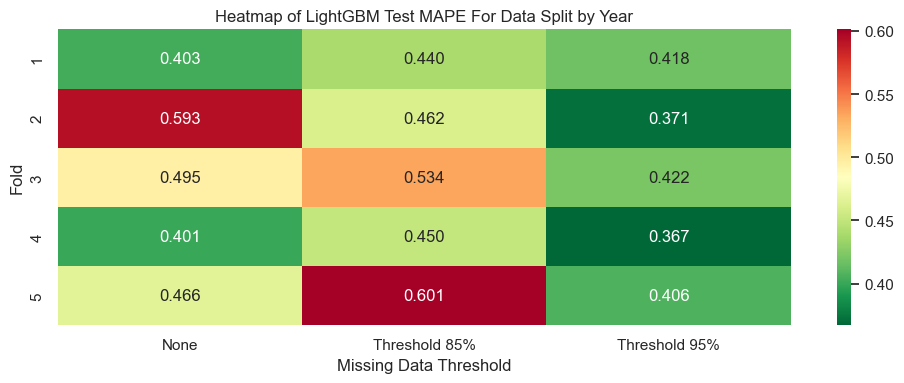

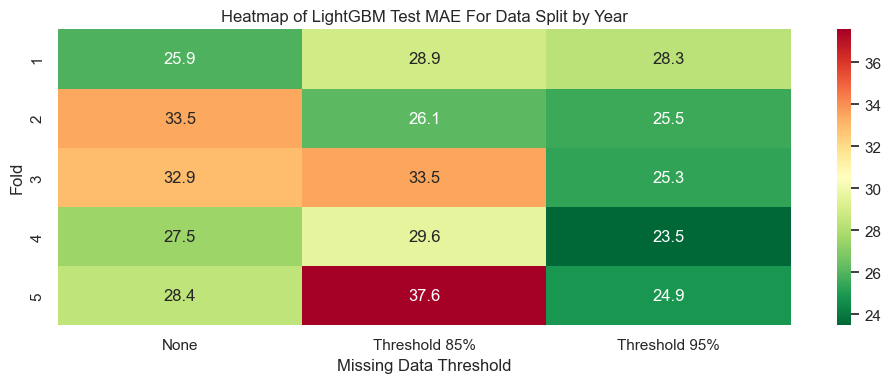

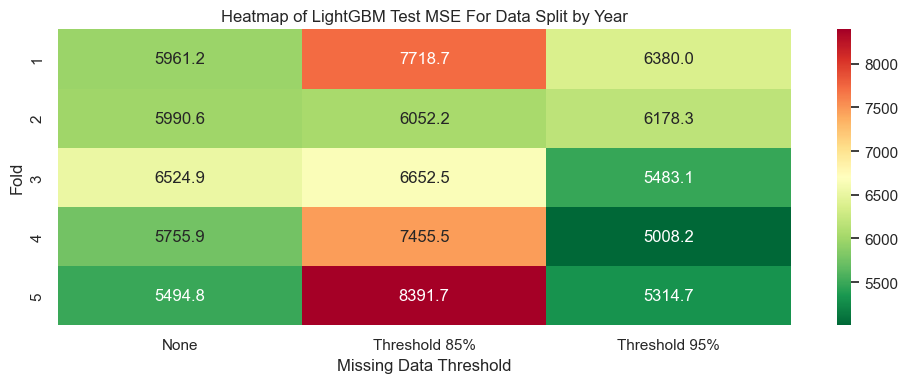

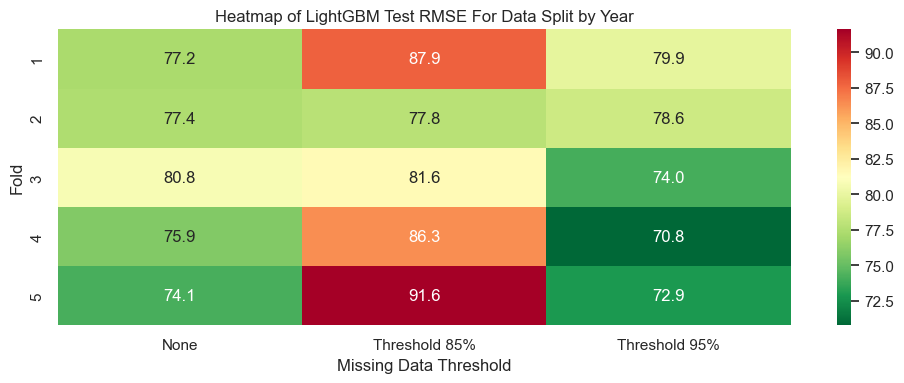

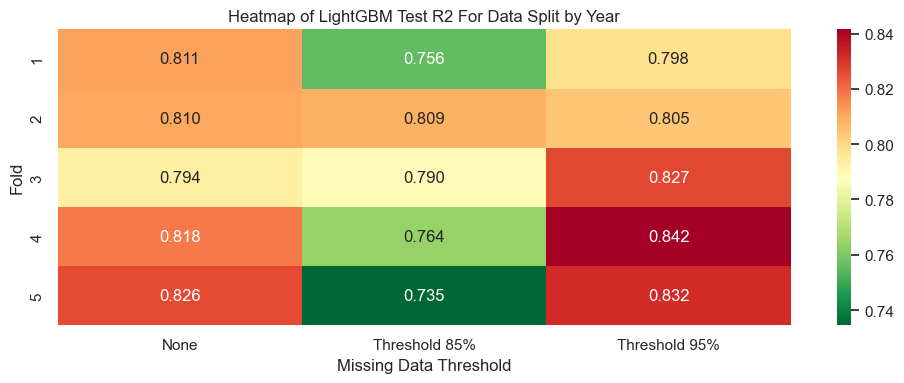

In [147]:
import seaborn as sns

data_lgbm = test_stats['LightGBM'].astype(float)

for metric in data_lgbm.columns:
    plt.figure(figsize=(10, 4))
    d = pd.DataFrame(data_lgbm[metric].unstack(level='Missing Data Threshold'))
    if metric == 'MAPE' or metric == 'R2':
        fmt = ".3f"
    else:
        fmt = ".1f"
    sns.heatmap(d, annot=True, fmt=fmt, cmap="RdYlGn_r", cbar=True)
    sns.set_theme(context='notebook', style='whitegrid')  # or 'paper'
    plt.title("Heatmap of LightGBM Test " + metric + " For Data Split by Year")
    plt.xlabel("Missing Data Threshold")
    plt.ylabel("Fold")
    plt.tight_layout()
    plt.show()

In [148]:
lgbm_data = test_stats['LightGBM'].astype(float)
mean_summary_lgbm = lgbm_data.groupby(level='Missing Data Threshold').mean()
mean_summary_lgbm = mean_summary_lgbm.astype('float')
mean_summary_lgbm = mean_summary_lgbm.round(2)
std_summary_lgbm = lgbm_data.groupby(level='Missing Data Threshold').std()
std_summary_lgbm = std_summary_lgbm.astype('float')
std_summary_lgbm = std_summary_lgbm.round(2)

In [149]:
mean_corr_lgbm = mean_summary_lgbm.corr()
mean_corr_lgbm

Evaluation Metric,MAPE,MAE,MSE,RMSE,R2
Evaluation Metric,,,,,
MAPE,1.000000,0.999316,0.831723,0.840383,-0.847024
MAE,0.999316,1.000000,0.810626,0.819768,-0.826791
MSE,0.831723,0.810626,1.000000,0.999875,-0.999604
RMSE,0.840383,0.819768,0.999875,1.000000,-0.999923
R2,-0.847024,-0.826791,-0.999604,-0.999923,1.000000


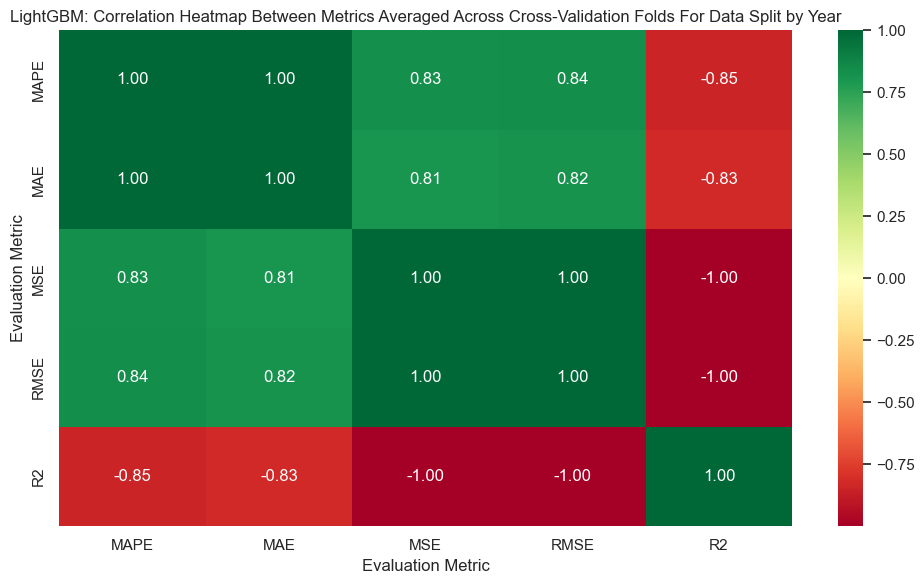

In [150]:
plt.figure(figsize=(10, 6))
sns.heatmap(mean_corr_lgbm, annot=True, fmt=".2f", cmap="RdYlGn", center=0)
plt.title("LightGBM: Correlation Heatmap Between Metrics Averaged Across Cross-Validation Folds For Data Split by Year")
plt.tight_layout()
plt.show()

### XGBoost

#### Data Collection

In [151]:
xgb_params = pd.DataFrame(index=index_rows, columns=['number_trees', 'max_tree_depth', 'boosting_type', 
                                                     'subsample', 'learning_rate','l1_norm', 'l2_norm'])

In [152]:
test_data_x['setting'] = test_data_x['setting'].astype("category")
testing_x = test_data_x.copy()

for fold, fold_num in enumerate(['1', '2', '3', '4', '5']):
    for thresh, thresh_name in enumerate(['Threshold 85%', 'Threshold 95%', 'None']):
        
        if thresh == 0:
            name = '85'
        elif thresh == 1:
            name = '95'
        else: name = '1'

        best_params = joblib.load(f"{output_dir}/xgboost/best_params_{fold}_{name}.pkl")
        param_list = list(best_params.values())
        xgb_params.loc[(thresh_name, fold_num)] = param_list

        train_input_data = train[fold][thresh * 2].copy()
        train_input_data['setting'] = train_input_data['setting'].astype("category")

        train_label = train[fold][thresh * 2 + 1].copy()

        columns_needed = testing_x.columns.intersection(train_input_data.columns)
        to_test = testing_x[columns_needed].copy()

        loaded_model = xgb.XGBRegressor(**best_params, enable_categorical=True)
        train_load = loaded_model.fit(train_input_data, train_label)
        prediction = train_load.predict(to_test)
        mse = mean_squared_error(test_data_y, prediction)
        mae = mean_absolute_error(test_data_y, prediction)
        rmse = np.sqrt(mse)
        r2 = r2_score(test_data_y, prediction)

        #to calculate mape
        num_predictions = len(prediction)
        mape = 0
        for p in range(0, num_predictions):
            mape += np.abs(prediction[p] - test_data_y.iloc[p]) / np.maximum(np.abs(prediction[p]), np.abs(test_data_y.iloc[p]))
        mape = mape/num_predictions
        #mape = (1/num_predictions) * np.sum(np.abs(prediction - test_data_y) / np.max(np.abs(prediction), np.abs(test_data_y)))

        test_stats.loc[(thresh_name, fold_num), ('XGBoost', 'MSE')] = mse
        test_stats.loc[(thresh_name, fold_num), ('XGBoost', 'MAE')] = mae
        test_stats.loc[(thresh_name, fold_num), ('XGBoost', 'RMSE')] = rmse
        test_stats.loc[(thresh_name, fold_num), ('XGBoost', 'R2')] = r2
        test_stats.loc[(thresh_name, fold_num), ('XGBoost', 'MAPE')] = mape[0]
        

/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [15:48:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "boosting_type", "l1_norm", "l2_norm", "max_tree_depth", "number_trees" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_28867/1823461600.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_stats.loc[(thresh_name, fold_num), ('XGBoost', 'MAPE')] = mape[0]
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [15:48:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "boosting_type", "l1_norm", "l2_norm", "max_tree_depth", "number_trees" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/v

#### Visualisations

In [153]:
xgb_params

number_trees max_tree_depth boosting_type  \
Missing Data Threshold Fold                                             
Threshold 85%          1              10              6        gbtree   
                       2              32             22          dart   
                       3             175             13          dart   
                       4              15             24        gbtree   
                       5              28             10          dart   
Threshold 95%          1              36              6        gbtree   
                       2              10             25          dart   
                       3              55             17        gbtree   
                       4             112             17          dart   
                       5              44             15        gbtree   
None                   1             217             23          dart   
                       2              19             18        gbtree   
                       3              82              8          dart   
                       4              27             22          dart   
                       5             182             14        gbtree   

                            subsample learning_rate   l1_norm   l2_norm  
Missing Data Threshold Fold                                              
Threshold 85%          1     0.100259      0.018057   0.00096  0.000654  
                       2     0.138591      0.001983  0.000905  0.000204  
                       3     0.101001      0.001337  0.000641  0.000154  
                       4     0.513108           0.0  0.000984  0.000328  
                       5     0.618745      0.000274  0.000443  0.000557  
Threshold 95%          1     0.103312      0.000498  0.000946  0.000379  
                       2      0.11784      0.000017  0.000106  0.000255  
                       3     0.387127      0.001403  0.000921  0.000665  
                       4     0.125512      0.001267  0.000189  0.000831  
                       5     0.172631      0.005629  0.000004  0.000575  
None                   1     0.101999      0.000251   0.00035  0.000818  
                       2     0.418388      0.000037  0.000169  0.000129  
                       3     0.182737      0.001291  0.000111  0.000822  
                       4     0.184971      0.001208  0.000078  0.000246  
                       5     0.953018      0.000366  0.000733   0.00052

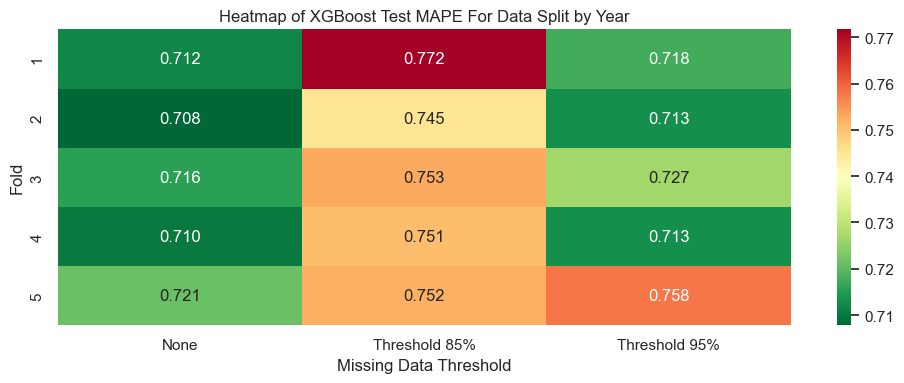

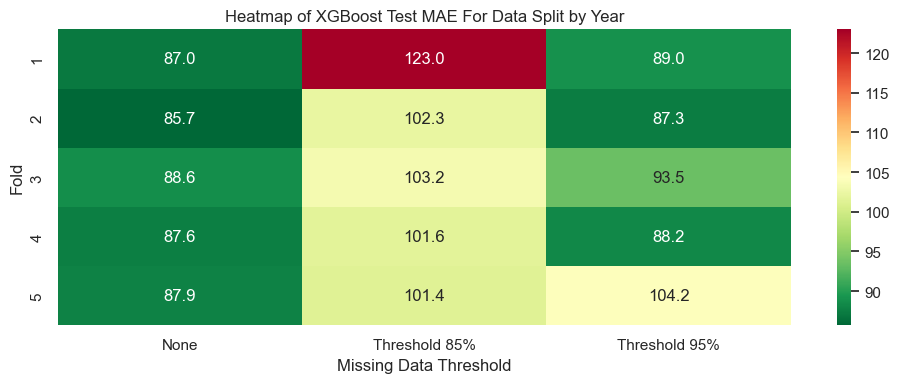

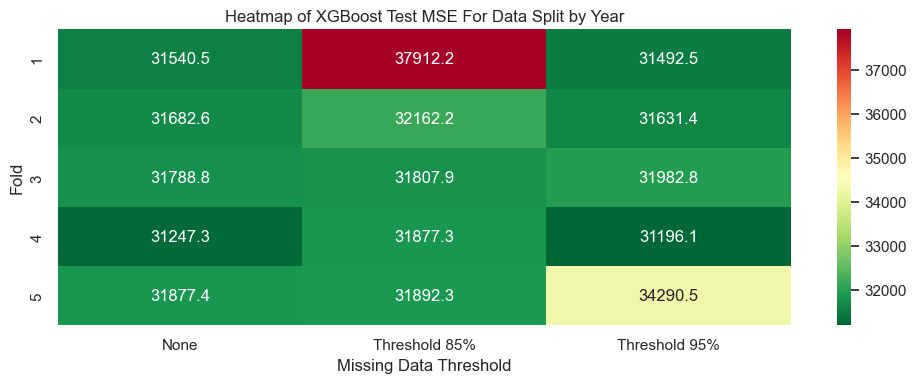

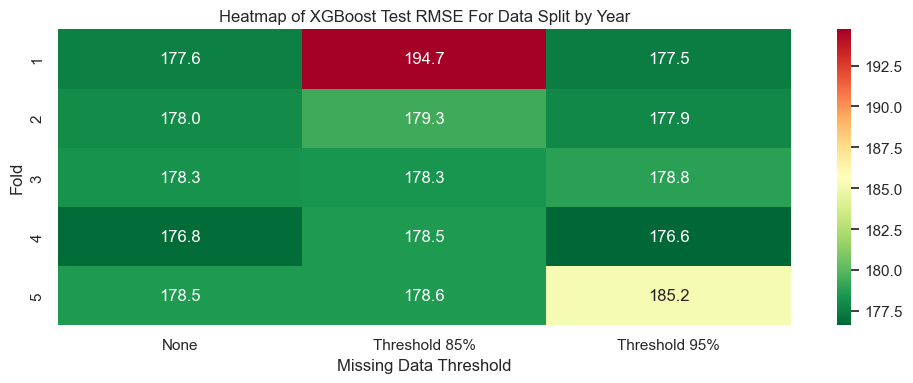

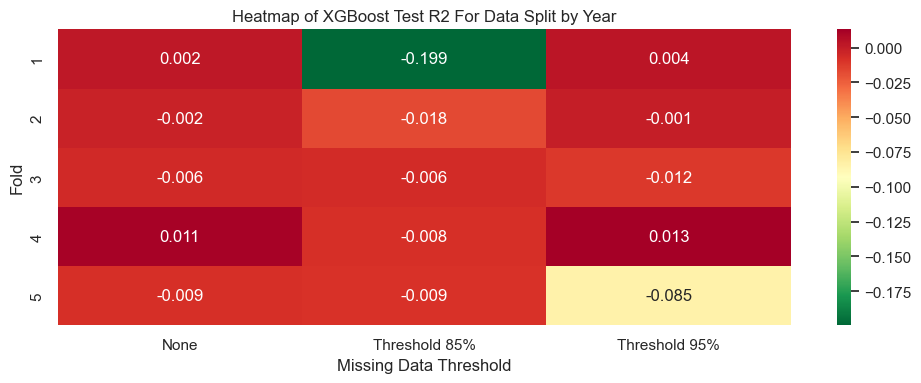

In [154]:
import seaborn as sns

data_lgbm = test_stats['XGBoost'].astype(float)

for metric in data_lgbm.columns:
    plt.figure(figsize=(10, 4))
    d = pd.DataFrame(data_lgbm[metric].unstack(level='Missing Data Threshold'))
    if metric == 'MAPE' or metric == 'R2':
        fmt = ".3f"
    else:
        fmt = ".1f"
    sns.heatmap(d, annot=True, fmt=fmt, cmap="RdYlGn_r", cbar=True)
    sns.set_theme(context='notebook', style='whitegrid')  # or 'paper'
    plt.title("Heatmap of XGBoost Test " + metric + " For Data Split by Year")
    plt.xlabel("Missing Data Threshold")
    plt.ylabel("Fold")
    plt.tight_layout()
    plt.show()

In [155]:
xgb_data = test_stats['XGBoost'].astype(float)
mean_summary_xgb = xgb_data.groupby(level='Missing Data Threshold').mean()
mean_summary_xgb = mean_summary_xgb.astype('float')
mean_summary_xgb = mean_summary_xgb.round(2)
std_summary_xgb = xgb_data.groupby(level='Missing Data Threshold').std()
std_summary_xgb = std_summary_xgb.astype('float')
std_summary_xgb = std_summary_xgb.round(2)

In [156]:
mean_corr_xgb = mean_summary_xgb.corr()
mean_corr_xgb

Evaluation Metric,MAPE,MAE,MSE,RMSE,R2
Evaluation Metric,,,,,
MAPE,1.000000,0.965784,0.980603,0.981807,-0.993399
MAE,0.965784,1.000000,0.997884,0.997459,-0.989158
MSE,0.980603,0.997884,1.000000,0.999981,-0.996613
RMSE,0.981807,0.997459,0.999981,1.000000,-0.997107
R2,-0.993399,-0.989158,-0.996613,-0.997107,1.000000


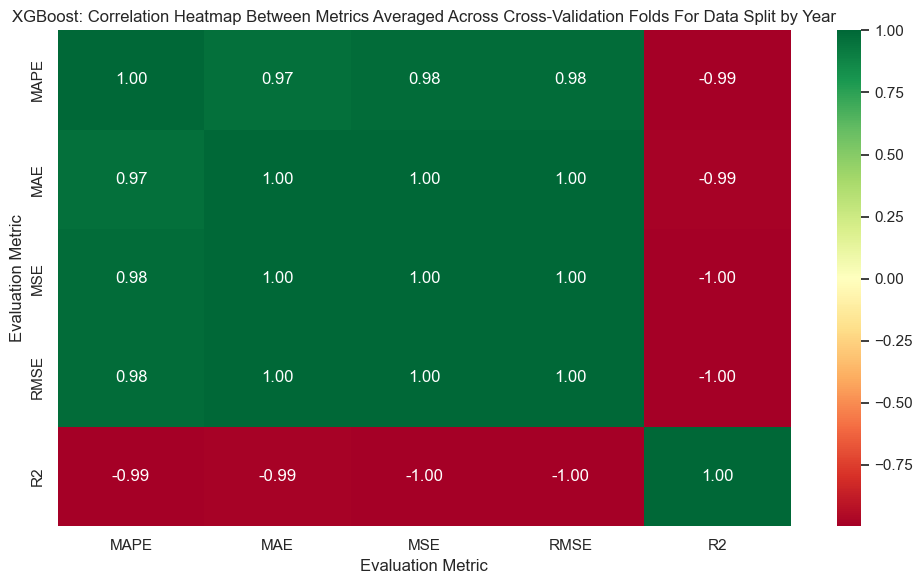

In [157]:
plt.figure(figsize=(10, 6))
sns.heatmap(mean_corr_xgb, annot=True, fmt=".2f", cmap="RdYlGn", center=0)
plt.title("XGBoost: Correlation Heatmap Between Metrics Averaged Across Cross-Validation Folds For Data Split by Year")
plt.tight_layout()
plt.show()

### Random Forest

#### Data Collection

In [71]:
rf_params = pd.DataFrame(index=index_rows, columns=['n_estimators', 'max_depth', 'min_samples_split', 
                                                     'bootstrapping', 'max_samples'])

In [72]:
testing_x_rf = testing_x.copy()
testing_x_rf['setting'] = testing_x_rf['setting'].map(countries_dict)

for fold, fold_num in enumerate(['1', '2', '3', '4', '5']):
    for thresh, thresh_name in enumerate(['Threshold 85%', 'Threshold 95%', 'None']):
        
        if thresh == 0:
            name = '85'
        elif thresh == 1:
            name = '95'
        else: name = '1'

        best_params = joblib.load(f"{output_dir}/random_forest/best_params_{fold}_{name}.pkl")
        param_list = list(best_params.values())
        rf_params.loc[(thresh_name, fold_num)] = param_list
        train_input_data = train[fold][thresh * 2].copy()
        train_input_data['setting'] = train_input_data['setting'].map(countries_dict)

        columns_needed = testing_x_rf.columns.intersection(train_input_data.columns)
        test_relevant_input = testing_x_rf[columns_needed]

        loaded_model = RandomForestRegressor(**best_params)
        train_load = loaded_model.fit(train_input_data, train[fold][thresh * 2 + 1])
        prediction = train_load.predict(test_relevant_input)
        mse = mean_squared_error(test_data_y, prediction)
        mae = mean_absolute_error(test_data_y, prediction)
        rmse = np.sqrt(mse)
        r2 = r2_score(test_data_y, prediction)

        #to calculate mape
        num_predictions = len(prediction)
        mape = 0
        for p in range(0, num_predictions):
            mape += np.abs(prediction[p] - test_data_y.iloc[p]) / np.maximum(np.abs(prediction[p]), np.abs(test_data_y.iloc[p]))
        
        mape = mape/num_predictions

        test_stats.loc[(thresh_name, fold_num), ('Random Forest', 'MSE')] = mse
        test_stats.loc[(thresh_name, fold_num), ('Random Forest', 'MAE')] = mae
        test_stats.loc[(thresh_name, fold_num), ('Random Forest', 'RMSE')] = rmse
        test_stats.loc[(thresh_name, fold_num), ('Random Forest', 'R2')] = r2
        test_stats.loc[(thresh_name, fold_num), ('Random Forest', 'MAPE')] = mape[0]
        

/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_28867/1829316102.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_stats.loc[(thresh_name, fold_num), ('Random Forest', 'MAPE')] = mape[0]
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_28867/182

#### Visualisations

In [101]:
rf_params

n_estimators max_depth min_samples_split  \
Missing Data Threshold Fold                                            
Threshold 85%          1              53        16                 4   
                       2             286         3                 2   
                       3             164         5                 3   
                       4              20         7                 4   
                       5              10         5                 2   
Threshold 95%          1             230        16                 2   
                       2              32        17                 2   
                       3              41        13                 6   
                       4             126        14                 2   
                       5              11        14                 3   
None                   1             140        22                 3   
                       2              26        24                 8   
                       3             219        14                 4   
                       4             244        19                 2   
                       5             213        16                 2   

                            bootstrapping max_samples  
Missing Data Threshold Fold                            
Threshold 85%          1             True    0.030677  
                       2             True    0.075483  
                       3             True    0.207149  
                       4             True    0.058112  
                       5             True    0.332235  
Threshold 95%          1             True    0.806456  
                       2             True    0.495449  
                       3             True    0.768081  
                       4             True     0.31039  
                       5             True    0.994299  
None                   1             True    0.967463  
                       2             True    0.512976  
                       3             True    0.979654  
                       4             True    0.417778  
                       5             True    0.999366

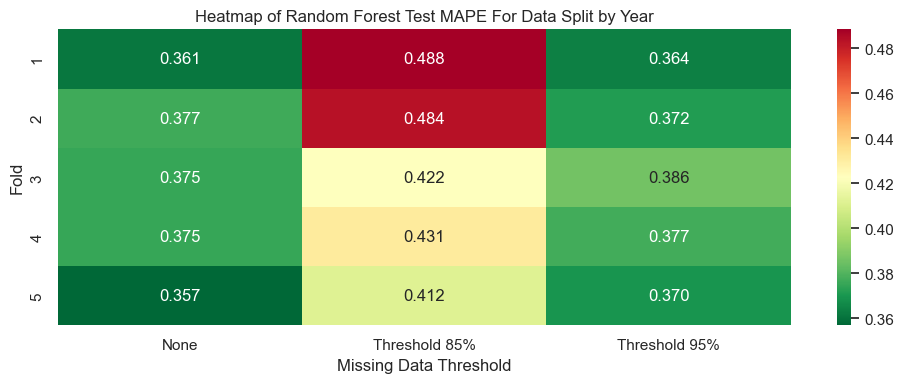

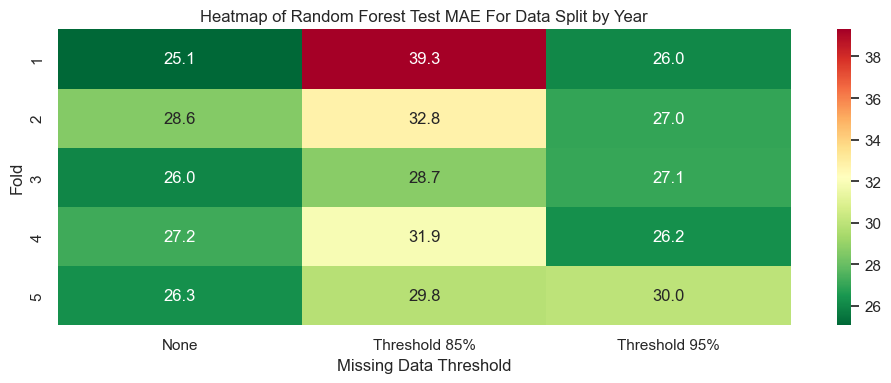

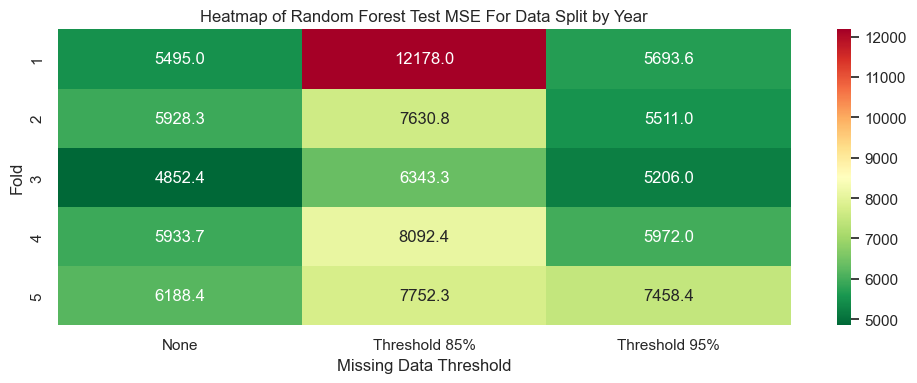

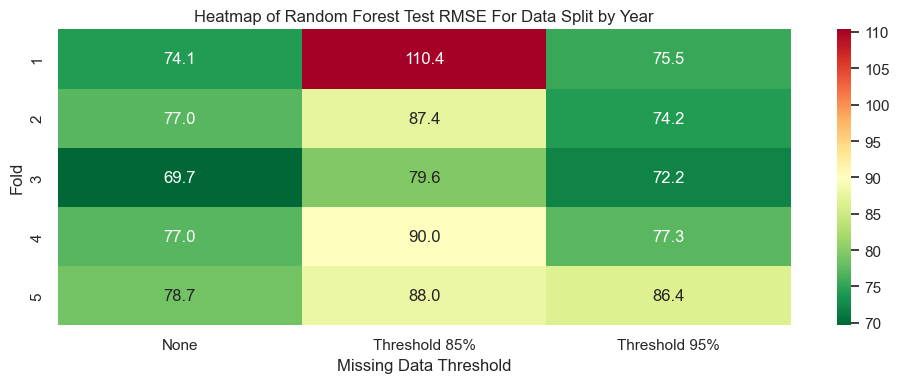

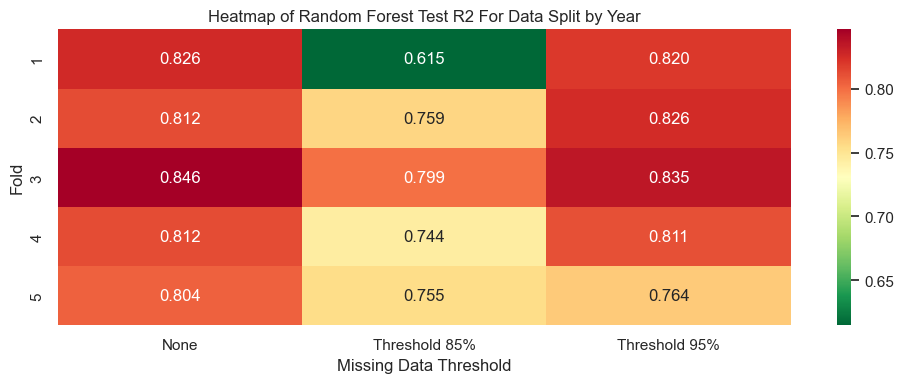

In [97]:
import seaborn as sns

data_rf = test_stats['Random Forest'].astype(float)

for metric in data_rf.columns:
    plt.figure(figsize=(10, 4))
    d = pd.DataFrame(data_rf[metric].unstack(level='Missing Data Threshold'))
    if metric == 'MAPE' or metric == 'R2':
        fmt = ".3f"
    else:
        fmt = ".1f"
    sns.heatmap(d, annot=True, fmt=fmt, cmap="RdYlGn_r", cbar=True)
    sns.set_theme(context='notebook', style='whitegrid')  # or 'paper'
    plt.title("Heatmap of Random Forest Test " + metric + " For Data Split by Year")
    plt.xlabel("Missing Data Threshold")
    plt.ylabel("Fold")
    plt.tight_layout()
    plt.show()

In [74]:
rf_data = test_stats['Random Forest'].astype(float)
mean_summary_rf = rf_data.groupby(level='Missing Data Threshold').mean()
mean_summary_rf = mean_summary_rf.astype('float')
mean_summary_rf = mean_summary_rf.round(2)
std_summary_rf = rf_data.groupby(level='Missing Data Threshold').std()
std_summary_rf = std_summary_rf.astype('float')
std_summary_rf = std_summary_rf.round(2)

In [75]:
mean_corr_rf = mean_summary_rf.corr()
mean_corr_rf

Evaluation Metric,MAPE,MAE,MSE,RMSE,R2
Evaluation Metric,,,,,
MAPE,1.000000,0.994905,0.995323,0.994550,-0.994850
MAE,0.994905,1.000000,0.999991,0.999994,-1.000000
MSE,0.995323,0.999991,1.000000,0.999970,-0.999989
RMSE,0.994550,0.999994,0.999970,1.000000,-0.999996
R2,-0.994850,-1.000000,-0.999989,-0.999996,1.000000


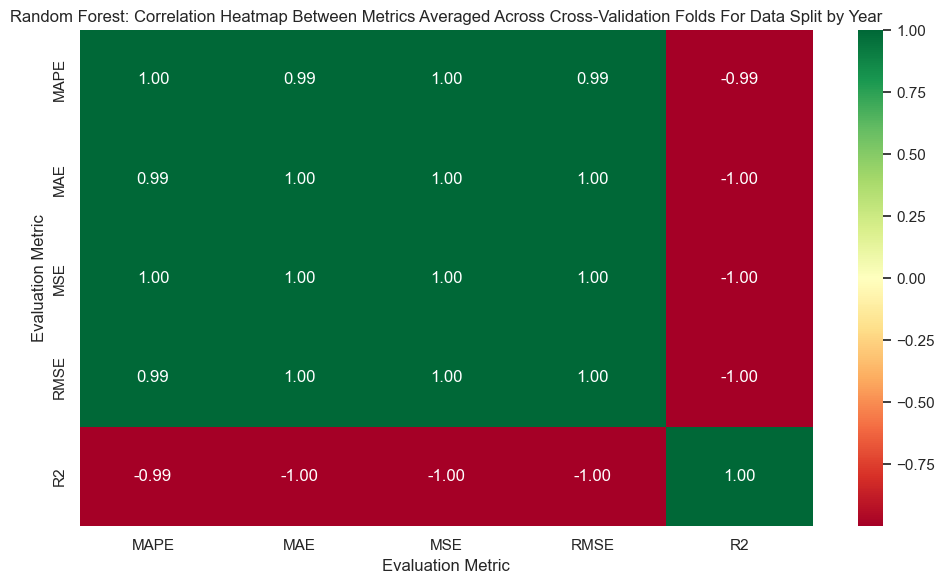

In [98]:
plt.figure(figsize=(10, 6))
sns.heatmap(mean_corr_rf, annot=True, fmt=".2f", cmap="RdYlGn", center=0)
plt.title("Random Forest: Correlation Heatmap Between Metrics Averaged Across Cross-Validation Folds For Data Split by Year")
plt.tight_layout()
plt.show()

### Comparison Visualisations

In [158]:
mean_concat = pd.concat([mean_summary_lgbm, mean_summary_xgb, mean_summary_rf], axis=1)
mean_concat.columns = pd.MultiIndex.from_tuples([('LightGBM', 'MAPE'), ('LightGBM', 'MAE'), ('LightGBM', 'MSE'), ('LightGBM', 'RMSE'), ('LightGBM', 'R2'), 
     ('XGBoost', 'MAPE'), ('XGBoost', 'MAE'), ('XGBoost', 'MSE'), ('XGBoost', 'RMSE'), ('XGBoost', 'R2'),
     ('Random Forest', 'MAPE'), ('Random Forest', 'MAE'), ('Random Forest', 'MSE'), ('Random Forest', 'RMSE'), ('Random Forest', 'R2')], names=['Model', 'Metric'])
mean_concat

Model                  LightGBM                              XGBoost          \
Metric                     MAPE    MAE      MSE   RMSE    R2    MAPE     MAE   
Missing Data Threshold                                                         
None                       0.47  29.64  5945.48  77.08  0.81    0.71   87.37   
Threshold 85%              0.50  31.14  7254.13  85.03  0.77    0.75  106.29   
Threshold 95%              0.40  25.50  5672.85  75.24  0.82    0.73   92.43   

Model                                          Random Forest                  \
Metric                       MSE    RMSE    R2          MAPE    MAE      MSE   
Missing Data Threshold                                                         
None                    31627.32  177.84 -0.00          0.37  26.61  5679.57   
Threshold 85%           33130.37  181.90 -0.05          0.45  32.49  8399.37   
Threshold 95%           32118.66  179.19 -0.02          0.37  27.26  5968.20   

Model                                
Metric                   RMSE    R2  
Missing Data Threshold               
None                    75.30  0.82  
Threshold 85%           91.07  0.73  
Threshold 95%           77.10  0.81

In [159]:
std_concat = pd.concat([std_summary_lgbm, std_summary_xgb, std_summary_rf], axis=1)
std_concat.columns = pd.MultiIndex.from_tuples([('LightGBM', 'MAPE'), ('LightGBM', 'MAE'), ('LightGBM', 'MSE'), ('LightGBM', 'RMSE'), ('LightGBM', 'R2'), 
     ('XGBoost', 'MAPE'), ('XGBoost', 'MAE'), ('XGBoost', 'MSE'), ('XGBoost', 'RMSE'), ('XGBoost', 'R2'),
     ('Random Forest', 'MAPE'), ('Random Forest', 'MAE'), ('Random Forest', 'MSE'), ('Random Forest', 'RMSE'), ('Random Forest', 'R2')], names=['Model', 'Metric'])
std_concat

Model                  LightGBM                           XGBoost        \
Metric                     MAPE   MAE     MSE  RMSE    R2    MAPE   MAE   
Missing Data Threshold                                                    
None                       0.08  3.38  379.80  2.45  0.01    0.01  1.09   
Threshold 85%              0.07  4.46  916.13  5.42  0.03    0.01  9.36   
Threshold 95%              0.03  1.76  583.46  3.86  0.02    0.02  6.97   

Model                                       Random Forest                 \
Metric                      MSE  RMSE    R2          MAPE   MAE      MSE   
Missing Data Threshold                                                     
None                     246.78  0.69  0.01          0.01  1.34   525.26   
Threshold 85%           2676.50  7.17  0.08          0.04  4.13  2214.12   
Threshold 95%           1246.59  3.44  0.04          0.01  1.58   878.37   

Model                                
Metric                   RMSE    R2  
Missing Data Threshold               
None                     3.55  0.02  
Threshold 85%           11.47  0.07  
Threshold 95%            5.50  0.03

In [163]:
joblib.dump(mean_concat, f"../../split_year_models/base_mean_metrics.pkl")
joblib.dump(std_concat, f"../../split_year_models/base_std_metrics.pkl")

['../../split_year_models/base_std_metrics.pkl']

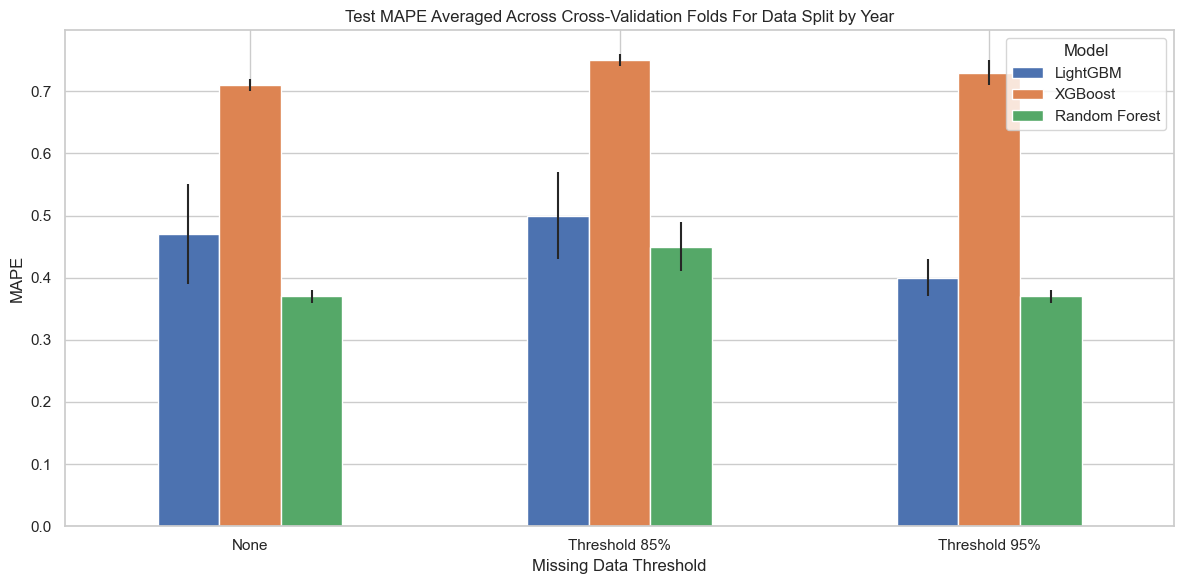

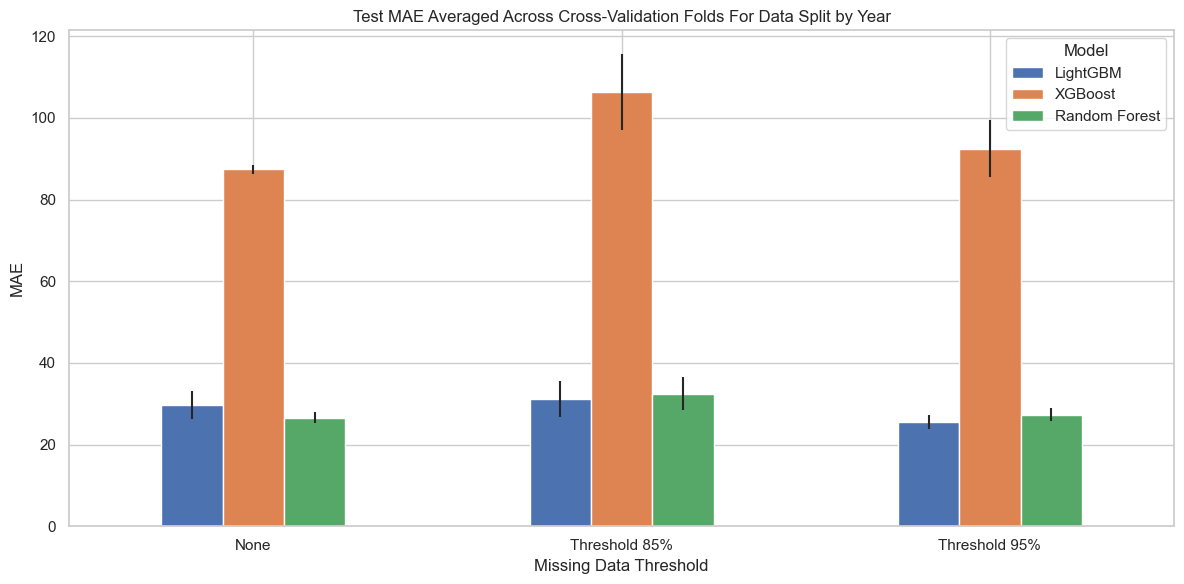

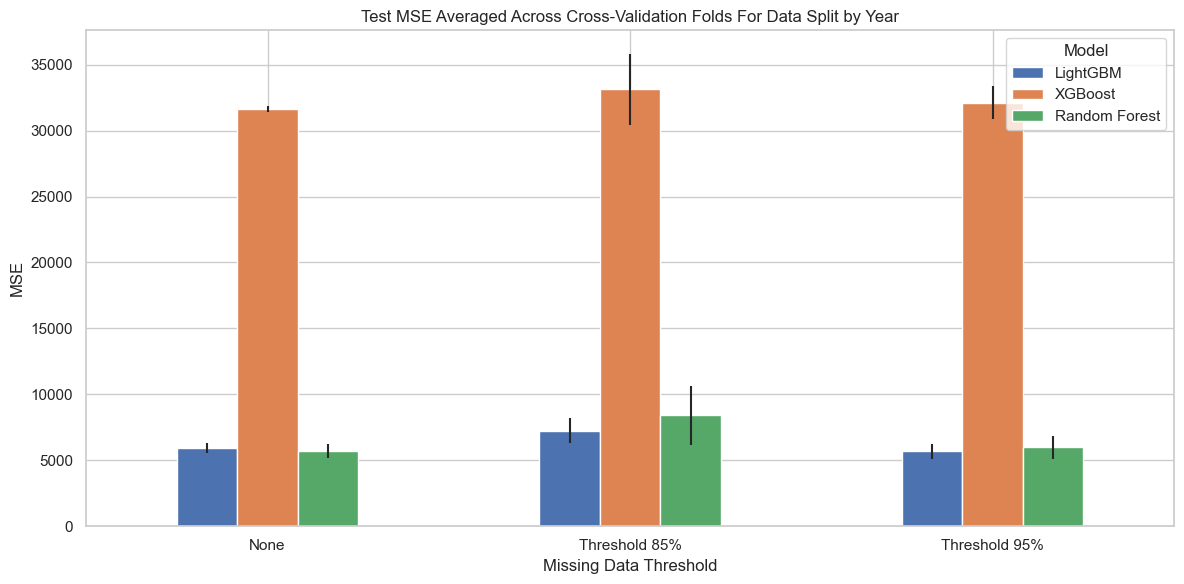

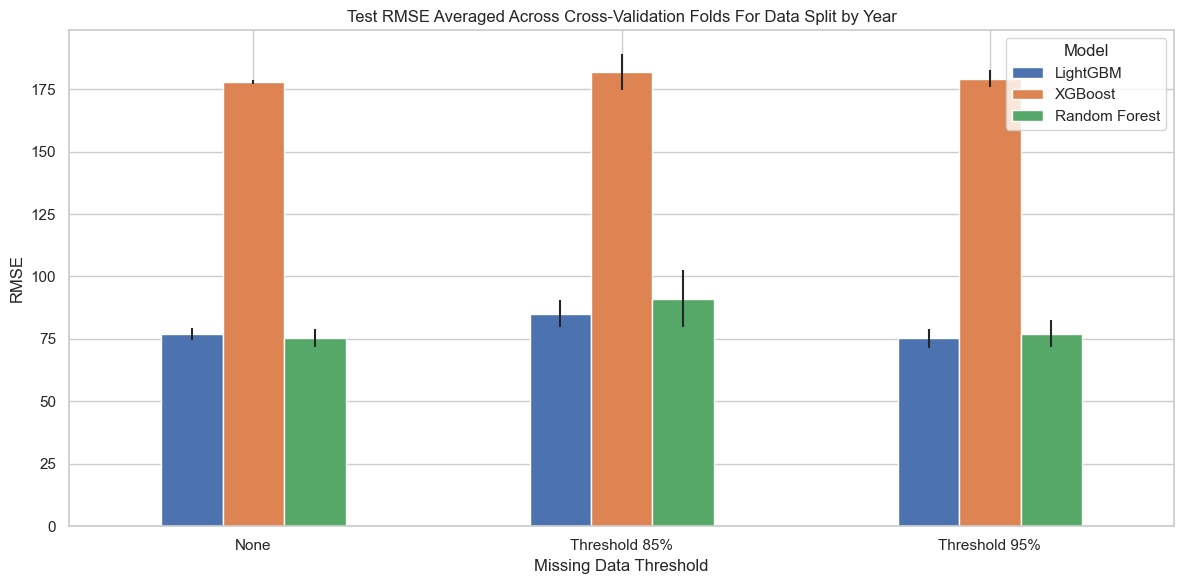

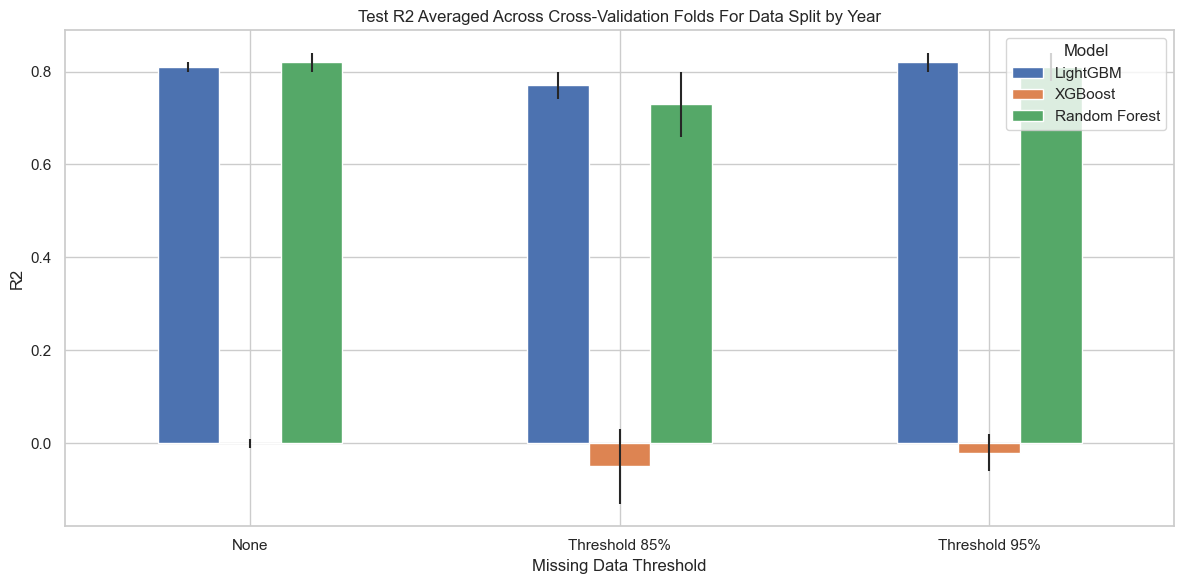

In [160]:
mean_concat = mean_concat.astype(float)
std_concat = std_concat.astype(float)

metrics = ['MAPE', 'MAE', "MSE", 'RMSE', "R2"]
bar_index = mean_concat.index

for metric in metrics:
    data_metric = mean_concat.xs(metric, axis=1, level='Metric')
    error = std_concat.xs(metric, axis=1, level='Metric')
    ax = data_metric.plot.bar(rot=0, yerr=error, figsize=(12, 6))     
    plt.title("Test " + metric + " Averaged Across Cross-Validation Folds For Data Split by Year")
    plt.xlabel("Missing Data Threshold")
    plt.ylabel(metric)
    plt.tight_layout()
    plt.show()

### Without XGB

In [161]:
without_xgb = mean_concat.drop(columns=['XGBoost'], axis=1)
without_xgb_std = std_concat.drop(columns=['XGBoost'], axis=1)

/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_28867/2683943296.py:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  without_xgb = mean_concat.drop(columns=['XGBoost'], axis=1)
/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_28867/2683943296.py:2: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  without_xgb_std = std_concat.drop(columns=['XGBoost'], axis=1)


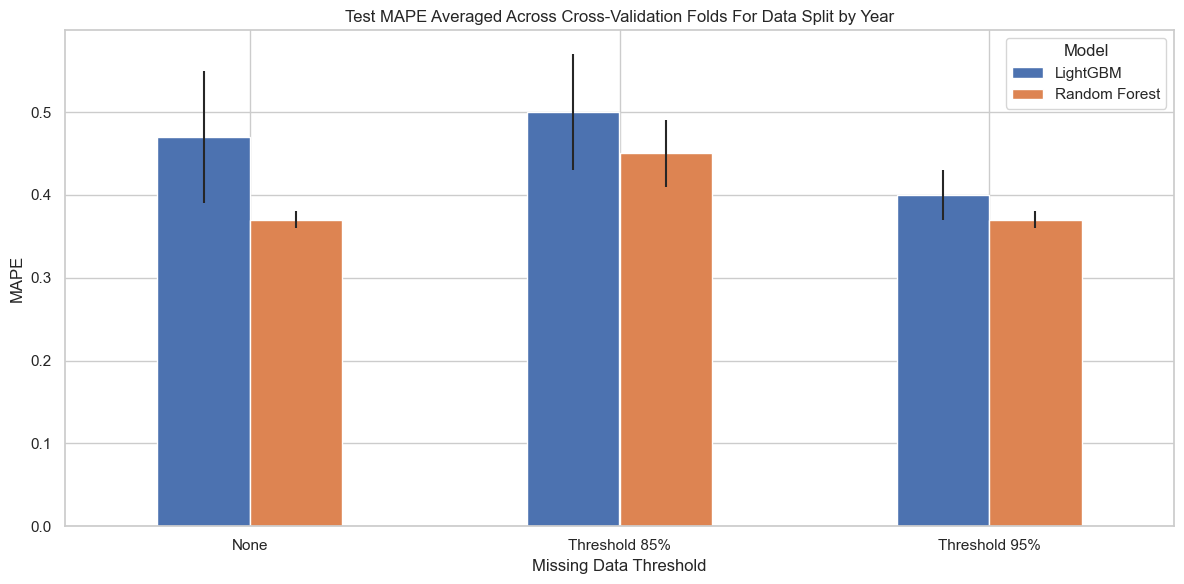

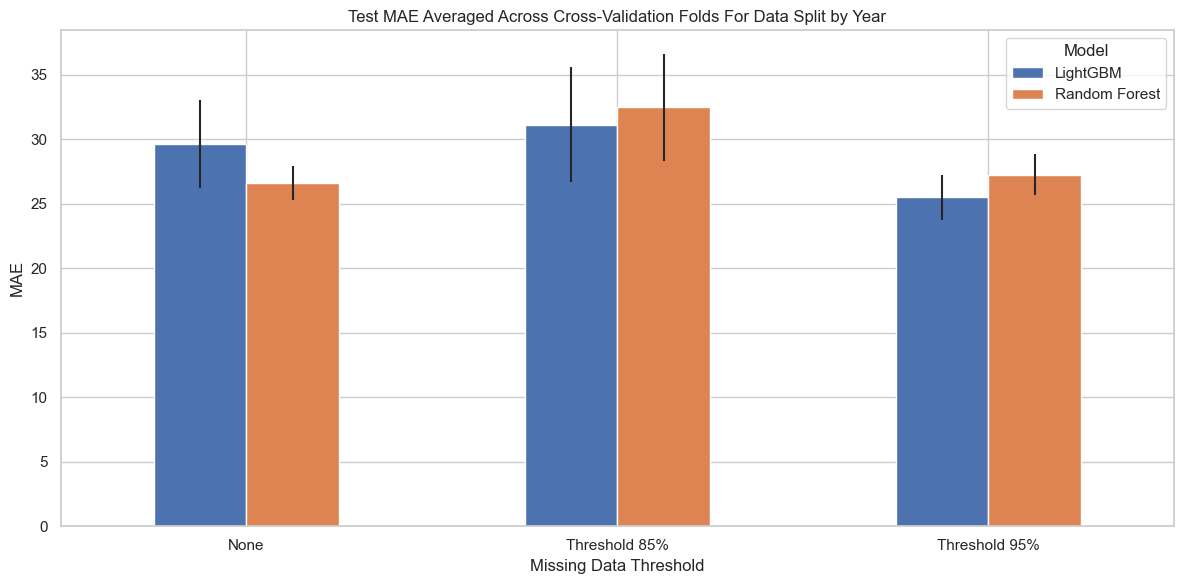

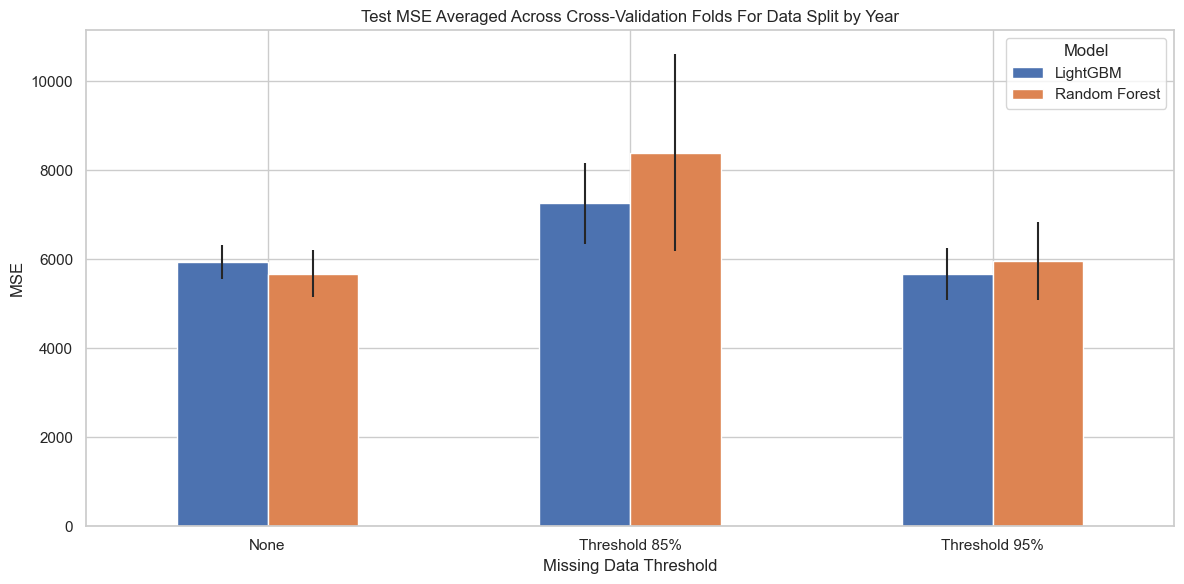

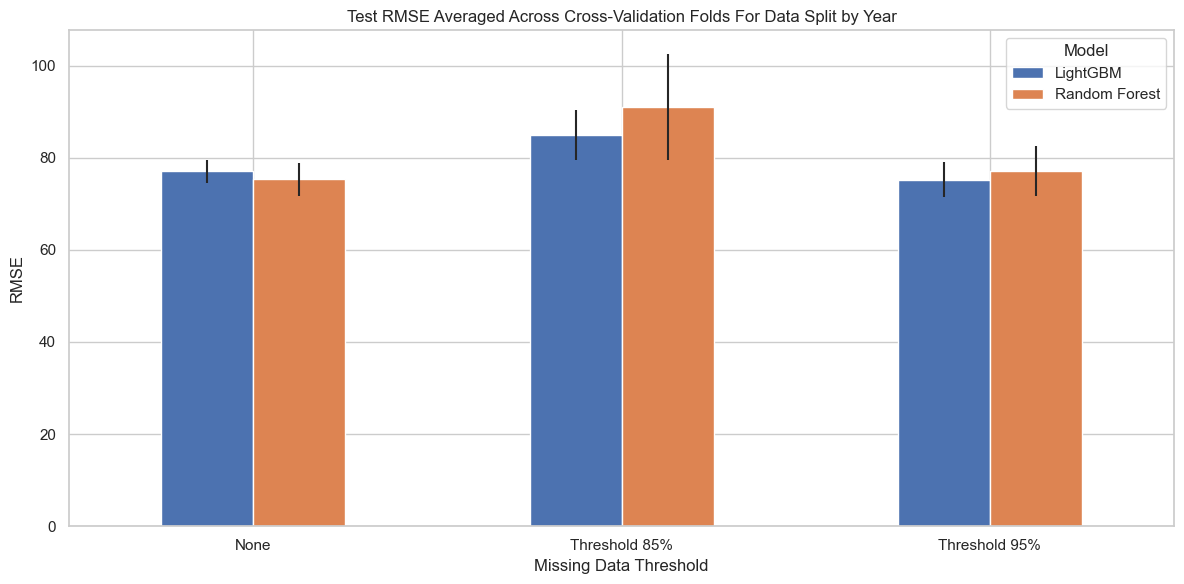

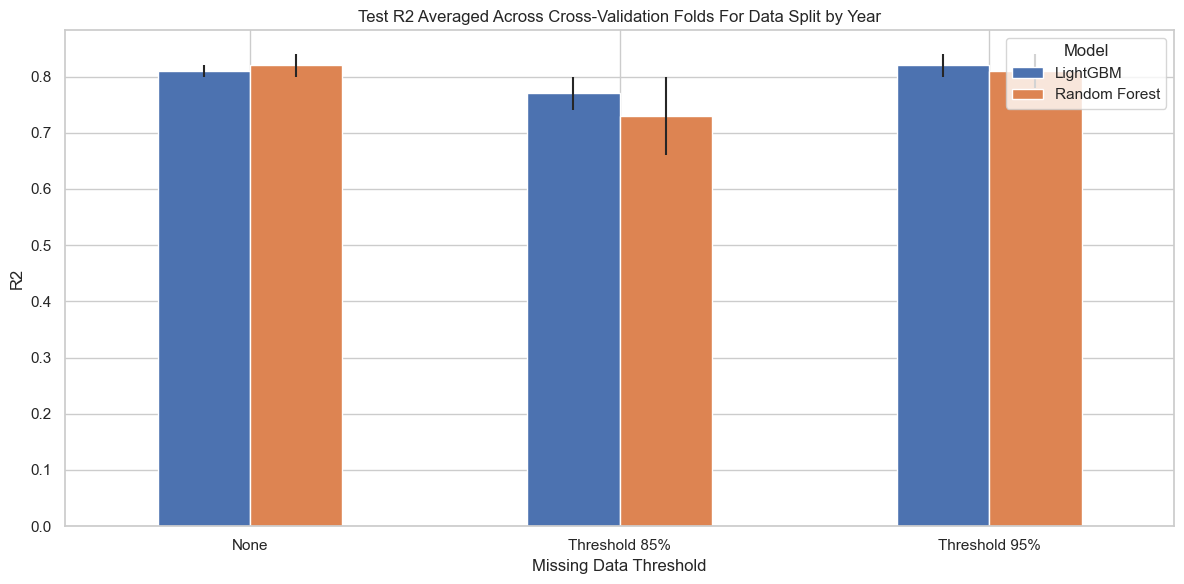

In [162]:
without_xgb = without_xgb.astype(float)
without_xgb_std = without_xgb_std.astype(float)

metrics = ['MAPE', 'MAE', "MSE", 'RMSE', "R2"]
bar_index = without_xgb.index

for metric in metrics:
    data_metric = without_xgb.xs(metric, axis=1, level='Metric')
    error = without_xgb_std.xs(metric, axis=1, level='Metric')
    ax = data_metric.plot.bar(rot=0, yerr=error, figsize=(12, 6))     
    plt.title("Test " + metric + " Averaged Across Cross-Validation Folds For Data Split by Year")
    plt.xlabel("Missing Data Threshold")
    plt.ylabel(metric)
    plt.tight_layout()
    plt.show()

### Test vs Validation

#### Data Gathering

In [164]:
validation_mse_stats = pd.DataFrame(index=index_rows, columns=['xgboost', 'lightgbm', 'random_forest'])

In [165]:
for fold, fold_num in enumerate(['1', '2', '3', '4', '5']):
    for thresh, thresh_name in enumerate(['Threshold 85%', 'Threshold 95%', 'None']):
        for model in ['xgboost', 'lightgbm', 'random_forest']:
        
            if thresh == 0:
                name = '85'
            elif thresh == 1:
                name = '95'
            else: name = '1'

            with open(f"{output_dir}/{model}/results_{fold}_{name}.json", 'r') as f:
                optuna_study = json.load(f)

            best_value = optuna_study["best_optuna_loss"]

            validation_mse_stats.loc[(thresh_name, fold_num), model] = best_value

In [166]:
mean_validation_mse = validation_mse_stats.groupby(level='Missing Data Threshold').mean()
mean_validation_mse = mean_validation_mse.astype('float')
std_validation_mse = validation_mse_stats.groupby(level='Missing Data Threshold').std()
std_validation_mse = std_validation_mse.astype('float')
mean_validation_mse.columns = ['XGBoost', 'LightGBM', 'Random Forest']
std_validation_mse.columns = ['XGBoost', 'LightGBM', 'Random Forest']

mean_concat_mse = mean_concat.xs('MSE', axis=1, level='Metric')
std_concat_mse = std_concat.xs('MSE', axis=1, level='Metric')

In [167]:
mean_none = pd.DataFrame(index=['XGBoost', 'LightGBM', 'Random Forest'], columns=['Validation MSE', 'Test MSE'])
mean_none.loc['XGBoost', 'Validation MSE'] = mean_validation_mse.loc['None', 'XGBoost']
mean_none.loc['LightGBM', 'Validation MSE'] = mean_validation_mse.loc['None', 'LightGBM']
mean_none.loc['Random Forest', 'Validation MSE'] = mean_validation_mse.loc['None', 'Random Forest']
mean_none.loc['XGBoost', 'Test MSE'] = mean_concat_mse.loc['None', 'XGBoost']
mean_none.loc['LightGBM', 'Test MSE'] = mean_concat_mse.loc['None', 'LightGBM']
mean_none.loc['Random Forest', 'Test MSE'] = mean_concat_mse.loc['None', 'Random Forest']

In [168]:
std_none = pd.DataFrame(index=['XGBoost', 'LightGBM', 'Random Forest'], columns=['Validation MSE', 'Test MSE'])
std_none.loc['XGBoost', 'Validation MSE'] = std_validation_mse.loc['None', 'XGBoost']
std_none.loc['LightGBM', 'Validation MSE'] = std_validation_mse.loc['None', 'LightGBM']
std_none.loc['Random Forest', 'Validation MSE'] = std_validation_mse.loc['None', 'Random Forest']
std_none.loc['XGBoost', 'Test MSE'] = std_concat_mse.loc['None', 'XGBoost']
std_none.loc['LightGBM', 'Test MSE'] = std_concat_mse.loc['None', 'LightGBM']
std_none.loc['Random Forest', 'Test MSE'] = std_concat_mse.loc['None', 'Random Forest']

In [169]:
mean_95 = pd.DataFrame(index=['XGBoost', 'LightGBM', 'Random Forest'], columns=['Validation MSE', 'Test MSE'])
mean_95.loc['XGBoost', 'Validation MSE'] = mean_validation_mse.loc['Threshold 95%', 'XGBoost']
mean_95.loc['LightGBM', 'Validation MSE'] = mean_validation_mse.loc['Threshold 95%', 'LightGBM']
mean_95.loc['Random Forest', 'Validation MSE'] = mean_validation_mse.loc['Threshold 95%', 'Random Forest']
mean_95.loc['XGBoost', 'Test MSE'] = mean_concat_mse.loc['Threshold 95%', 'XGBoost']
mean_95.loc['LightGBM', 'Test MSE'] = mean_concat_mse.loc['Threshold 95%', 'LightGBM']
mean_95.loc['Random Forest', 'Test MSE'] = mean_concat_mse.loc['Threshold 95%', 'Random Forest']

In [170]:
std_95 = pd.DataFrame(index=['XGBoost', 'LightGBM', 'Random Forest'], columns=['Validation MSE', 'Test MSE'])
std_95.loc['XGBoost', 'Validation MSE'] = std_validation_mse.loc['Threshold 95%', 'XGBoost']
std_95.loc['LightGBM', 'Validation MSE'] = std_validation_mse.loc['Threshold 95%', 'LightGBM']
std_95.loc['Random Forest', 'Validation MSE'] = std_validation_mse.loc['Threshold 95%', 'Random Forest']
std_95.loc['XGBoost', 'Test MSE'] = std_concat_mse.loc['Threshold 95%', 'XGBoost']
std_95.loc['LightGBM', 'Test MSE'] = std_concat_mse.loc['Threshold 95%', 'LightGBM']
std_95.loc['Random Forest', 'Test MSE'] = std_concat_mse.loc['Threshold 95%', 'Random Forest']

In [171]:
mean_85 = pd.DataFrame(index=['XGBoost', 'LightGBM', 'Random Forest'], columns=['Validation MSE', 'Test MSE'])
mean_85.loc['XGBoost', 'Validation MSE'] = mean_validation_mse.loc['Threshold 85%', 'XGBoost']
mean_85.loc['LightGBM', 'Validation MSE'] = mean_validation_mse.loc['Threshold 85%', 'LightGBM']
mean_85.loc['Random Forest', 'Validation MSE'] = mean_validation_mse.loc['Threshold 85%', 'Random Forest']
mean_85.loc['XGBoost', 'Test MSE'] = mean_concat_mse.loc['Threshold 85%', 'XGBoost']
mean_85.loc['LightGBM', 'Test MSE'] = mean_concat_mse.loc['Threshold 85%', 'LightGBM']
mean_85.loc['Random Forest', 'Test MSE'] = mean_concat_mse.loc['Threshold 85%', 'Random Forest']

In [172]:
std_85 = pd.DataFrame(index=['XGBoost', 'LightGBM', 'Random Forest'], columns=['Validation MSE', 'Test MSE'])
std_85.loc['XGBoost', 'Validation MSE'] = std_validation_mse.loc['Threshold 85%', 'XGBoost']
std_85.loc['LightGBM', 'Validation MSE'] = std_validation_mse.loc['Threshold 85%', 'LightGBM']
std_85.loc['Random Forest', 'Validation MSE'] = std_validation_mse.loc['Threshold 85%', 'Random Forest']
std_85.loc['XGBoost', 'Test MSE'] = std_concat_mse.loc['Threshold 85%', 'XGBoost']
std_85.loc['LightGBM', 'Test MSE'] = std_concat_mse.loc['Threshold 85%', 'LightGBM']
std_85.loc['Random Forest', 'Test MSE'] = std_concat_mse.loc['Threshold 85%', 'Random Forest']

#### Visualisation

In [173]:
mean_validation_scores = [mean_85, mean_95, mean_none]
std_validation_scores = [std_85, std_95, std_none]

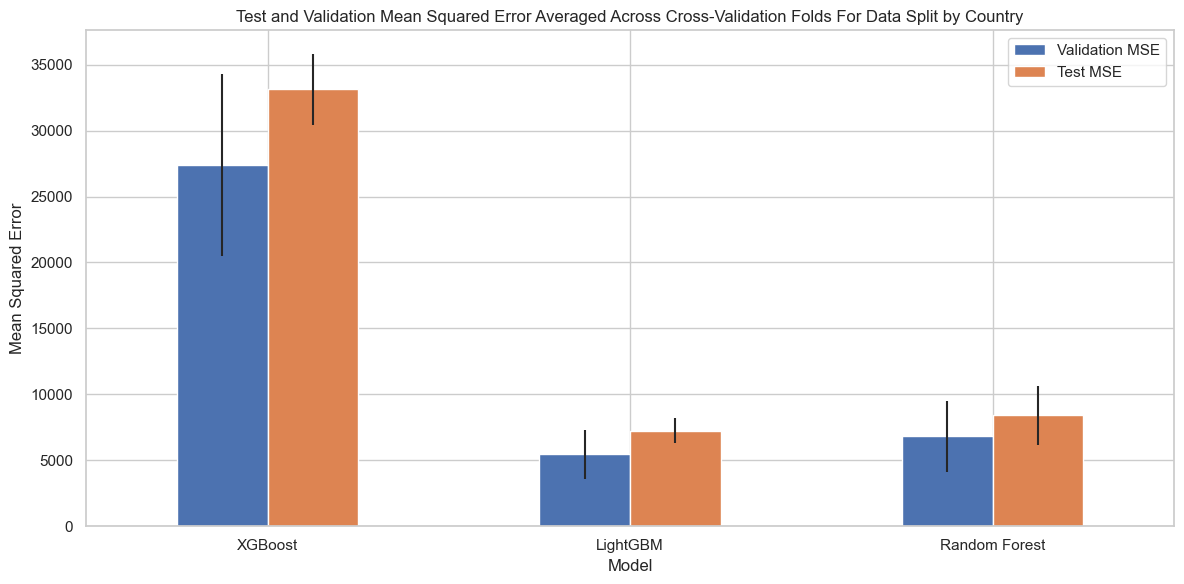

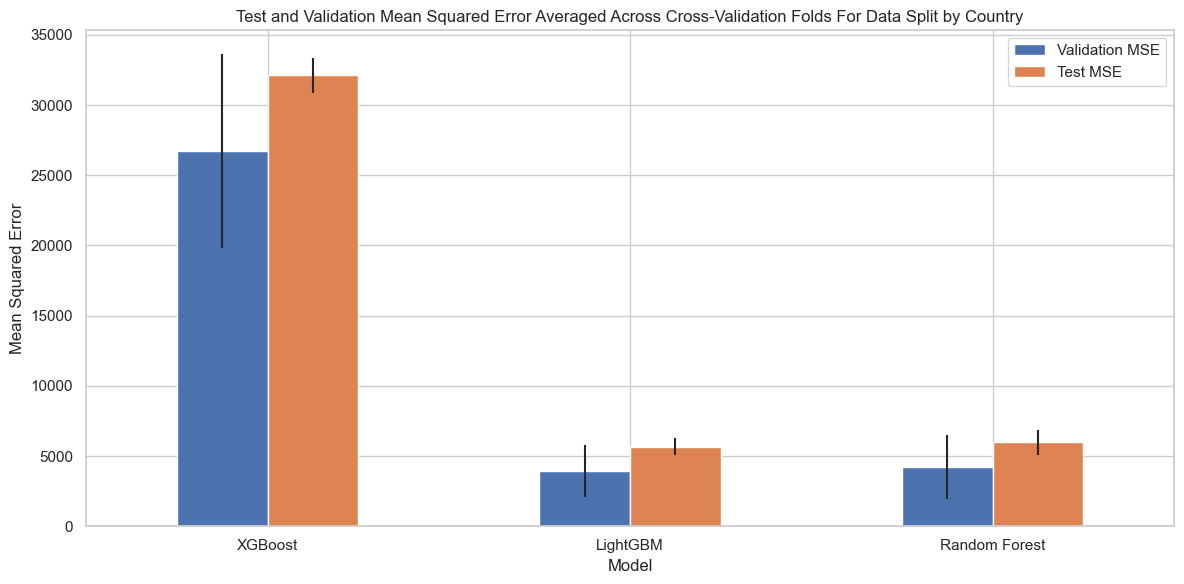

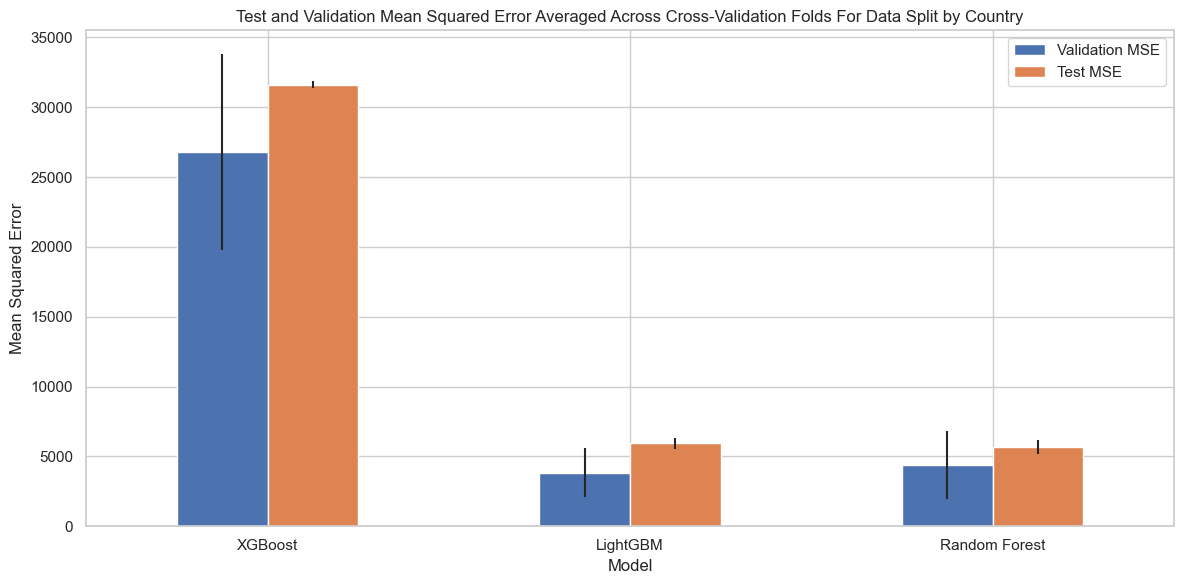

In [174]:
bar_index = ['XGBoost', 'LightGBM', 'Random Forest']

for i in range(3):

    ax = mean_validation_scores[i].plot.bar(rot=0, yerr=std_validation_scores[i], figsize=(12, 6))     
    plt.title("Test and Validation Mean Squared Error Averaged Across Cross-Validation Folds For Data Split by Country")
    plt.xlabel("Model")
    plt.ylabel('Mean Squared Error')
    plt.tight_layout()
    plt.show()

### Extras